# **Laboratorio 7**
- Gerardo Pineda 22880
- Angela García 22869
- Derek Arreaga 22537
- Mónica Salvatierra 22249
- Paula Barillas 22764

## **Task  1 - Práctica**
Para esta parte estarán resolviendo el problema de CartPole con Deep Q-Learning y una red de destino. Para esto, el
objetivo de este ejercicio es entrenar a un agente para que equilibre un poste en un carro (cartpole) en movimiento
durante el mayor tiempo posible. Se deberá usar Deep Q-Learning (DQL) con una red objetivo para lograr esto.


#### 1. Librerías

In [44]:
from collections import deque, namedtuple
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


#### 2. Entorno en Cartpole

In [45]:
np.random.seed(123)
torch.manual_seed(123)

env = gym.make("CartPole-v1", render_mode="rgb_array")
env


<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

In [46]:
obs, info = env.reset(seed=123)
obs_dim   = env.observation_space.shape[0]
action_dim= env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3. Definan las redes en línea y de destino:

Cree dos redes neuronales, la red en línea y la red de destino. La red
en línea se utiliza para la selección de acciones y se actualiza con más frecuencia, mientras que la red de
destino se utiliza para estimar los valores Q y se actualiza periódicamente. Ambas redes deberían tener una
arquitectura similar con capas de entrada y salida. Inicialmente, la red de destino debería tener los mismos
pesos que la red en línea.  

In [47]:
class QNetwork(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden=(128, 128)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden[0]),
            nn.ReLU(),
            nn.Linear(hidden[0], hidden[1]),
            nn.ReLU(),
            nn.Linear(hidden[1], action_dim)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

online_q = QNetwork(obs_dim, action_dim).to(device)
target_q = QNetwork(obs_dim, action_dim).to(device)

# target inicial
target_q.load_state_dict(online_q.state_dict())
for p in target_q.parameters():
    p.requires_grad = False
target_q.eval()

# Optimizador y loss
optimizer = optim.Adam(online_q.parameters(), lr=1e-3)
loss_fn   = nn.SmoothL1Loss()

# Sincronizacion de redes
def hard_update(target: nn.Module, source: nn.Module):
    target.load_state_dict(source.state_dict())

@torch.no_grad()
def soft_update(target: nn.Module, source: nn.Module, tau: float = 0.005):
    for tp, sp in zip(target.parameters(), source.parameters()):
        tp.data.mul_(1.0 - tau).add_(sp.data, alpha=tau)

#### 4. Establecer hiperparámetros
Defina hiperparámetros como el número de episodios, el tamaño de los
batches, el factor de descuento (gamma) y los parámetros de exploración (epsilon, epsilon decay, epsilon
mínimo). Ajuste estos hiperparámetros según sea necesario para optimizar el entrenamiento.


In [48]:
from dataclasses import dataclass
import torch

@dataclass
class DQNConfig:
    episodes: int = 500
    buffer_capacity: int = 50_000
    warmup_steps: int = 5_000
    batch_size: int = 64
    gamma: float = 0.99
    lr: float = 1e-3

    # Exploracion
    epsilon_start: float = 1.0
    epsilon_end: float = 0.03
    epsilon_decay_steps: int = 15_000
    use_exponential_eps: bool = False

    # Target network
    target_update_every: int = 1_000
    use_soft_update: bool = False
    tau: float = 0.005

    grad_clip: float = 10.0
    seed: int = 123

cfg = DQNConfig()

def epsilon_linear(step: int, cfg: DQNConfig):
    frac = min(1.0, step / cfg.epsilon_decay_steps)
    return cfg.epsilon_start + (cfg.epsilon_end - cfg.epsilon_start) * frac

def epsilon_exponential(step: int, cfg: DQNConfig):
    decay = (cfg.epsilon_end / cfg.epsilon_start) ** (1.0 / cfg.epsilon_decay_steps)
    return max(cfg.epsilon_end, cfg.epsilon_start * (decay ** step))

def get_epsilon(global_step: int, cfg: DQNConfig):
    if cfg.use_exponential_eps:
        return epsilon_exponential(global_step, cfg)
    return epsilon_linear(global_step, cfg)

#### 5. selección de acciones épsilon-greedy
Cree una función para la selección de acciones épsilon greedy. Esta función ayuda al agente a elegir acciones basadas en la política épsilon-greedy.


In [49]:
@torch.no_grad()
def select_action(state_np: np.ndarray, online_q: nn.Module, action_dim: int, device: torch.device, epsilon: float):
    if np.random.rand() < epsilon:
        return np.random.randint(action_dim)
    s = torch.tensor(state_np, dtype=torch.float32, device=device).unsqueeze(0)
    q = online_q(s)
    return int(q.argmax(dim=1).item())


In [50]:
# prueba para verrificar que funcione, no hace entrenamiento
global_step = 0
state, _ = env.reset(seed=cfg.seed)
done = False
taken = []
for _ in range(10):
    eps = get_epsilon(global_step, cfg)
    a = select_action(state, online_q, action_dim, device, eps)
    taken.append((a, round(eps, 3)))
    state, reward, terminated, truncated, _ = env.step(a)
    done = terminated or truncated
    global_step += 1
    if done:
        state, _ = env.reset(seed=cfg.seed)

print("Acciones (a, eps) en 10 pasos de prueba:", taken)


Acciones (a, eps) en 10 pasos de prueba: [(0, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (1, 0.999), (0, 0.999)]


#### 6. Defina la reproducción de la experiencia (experience replay):
Implemente una función para la reproducción de la experiencia, que es una parte crucial de DQL. Esta función ayuda al agente a aprender de una memoria
de repetición y a estabilizar el entrenamiento.


In [51]:
Transition = namedtuple("Transition", ("state", "action", "reward", "next_state", "done"))

class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append(Transition(state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)

memory = ReplayBuffer(cfg.buffer_capacity)


#### 7. Ciclo de entrenamiento:
Cree un ciclo para el entrenamiento del agente. En cada episodio, el agente
interactúa con el entorno, recopila experiencias y actualiza sus valores Q mediante la repetición de experiencias (experience replay). La red de destino se actualiza cada N episodios


In [52]:
def compute_loss(batch, online_q, target_q, cfg, device):
    states = torch.tensor(np.array(batch.state), dtype=torch.float32, device=device)
    actions = torch.tensor(batch.action, dtype=torch.int64, device=device).unsqueeze(1)
    rewards = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
    next_states = torch.tensor(np.array(batch.next_state), dtype=torch.float32, device=device)
    dones = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

    # Q(s,a)
    q_values = online_q(states).gather(1, actions)

    with torch.no_grad():
        next_q = target_q(next_states).max(1, keepdim=True)[0]
        target = rewards + cfg.gamma * (1 - dones) * next_q

    loss = loss_fn(q_values, target)
    return loss

returns = []
global_step = 0

for ep in range(cfg.episodes):
    state, _ = env.reset(seed=cfg.seed + ep)
    done = False
    total_reward = 0

    while not done:
        epsilon = get_epsilon(global_step, cfg)
        action = select_action(state, online_q, action_dim, device, epsilon)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        memory.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        global_step += 1

        if len(memory) >= cfg.warmup_steps:
            batch = memory.sample(cfg.batch_size)
            loss = compute_loss(batch, online_q, target_q, cfg, device)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(online_q.parameters(), cfg.grad_clip)
            optimizer.step()

            # Actualizar target
            if cfg.use_soft_update:
                soft_update(target_q, online_q, cfg.tau)
            elif global_step % cfg.target_update_every == 0:
                hard_update(target_q, online_q)

    returns.append(total_reward)

    if (ep+1) % 10 == 0:
        avg = np.mean(returns[-10:])
        print(f"Episodio {ep+1}, Retorno Promedio (últimos 10): {avg:.1f}")


Episodio 10, Retorno Promedio (últimos 10): 18.4
Episodio 20, Retorno Promedio (últimos 10): 24.7
Episodio 30, Retorno Promedio (últimos 10): 18.5
Episodio 40, Retorno Promedio (últimos 10): 22.5
Episodio 50, Retorno Promedio (últimos 10): 14.9
Episodio 60, Retorno Promedio (últimos 10): 21.1
Episodio 70, Retorno Promedio (últimos 10): 20.9
Episodio 80, Retorno Promedio (últimos 10): 23.0
Episodio 90, Retorno Promedio (últimos 10): 32.9
Episodio 100, Retorno Promedio (últimos 10): 18.9
Episodio 110, Retorno Promedio (últimos 10): 19.2
Episodio 120, Retorno Promedio (últimos 10): 20.0
Episodio 130, Retorno Promedio (últimos 10): 17.4
Episodio 140, Retorno Promedio (últimos 10): 25.9
Episodio 150, Retorno Promedio (últimos 10): 23.1
Episodio 160, Retorno Promedio (últimos 10): 18.5
Episodio 170, Retorno Promedio (últimos 10): 17.0
Episodio 180, Retorno Promedio (últimos 10): 19.4
Episodio 190, Retorno Promedio (últimos 10): 18.3
Episodio 200, Retorno Promedio (últimos 10): 21.4
Episodio 

#### 8. Representar el entorno:
Para visualizar el progreso del entrenamiento del agente, use env.render() para
mostrar el entorno CartPole durante el entrenamiento. Asegúrese de llamar a env.close() al final para limpiar
el renderizado

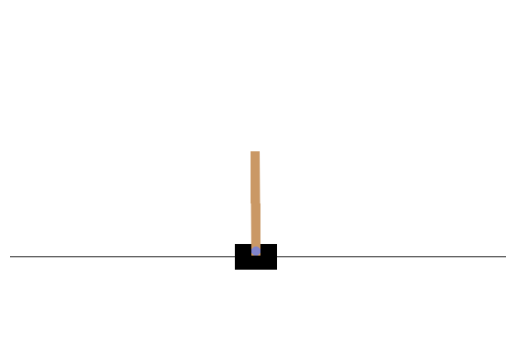

In [53]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

frames = []

state, _ = env.reset(seed=cfg.seed)
done = False
while not done:
    action = env.action_space.sample()
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    frames.append(env.render())

env.close()

plt.imshow(frames[-10])
plt.axis("off")
plt.show()

#### 9. Supervisar el entrenamiento:
Supervise el progreso del entrenamiento del agente, incluida la recompensa
total obtenida en cada episodio, para esto utilice una gráfica

In [54]:
def evaluate(env, online_q, episodes=10, render=False):
    total_rewards = []
    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        ep_reward = 0
        while not done:
            action = select_action(state, online_q, action_dim, device, epsilon=0.0)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_reward += reward
            if render:
                env.render()
        total_rewards.append(ep_reward)
    return np.mean(total_rewards)

avg_reward = evaluate(env, online_q, episodes=10, render=False)
print(f"Recompensa promedio en evaluación: {avg_reward}")
env.close()


Recompensa promedio en evaluación: 120.5


#### 10. Evalúe el rendimiento:
Una vez que se complete el entrenamiento, evalúe el rendimiento del agente
probándolo en el entorno CartPole sin renderizar y observe qué tan bien puede equilibrar el poste.


In [55]:
## Evaluación sin renderizar (múltiples episodios)
def detailed_evaluation(env, online_q, num_episodes=100, verbose=True):
    episode_rewards = []
    episode_lengths = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        steps = 0
        
        while not done:
            # Acción puramente explotativa (epsilon = 0)
            action = select_action(state, online_q, action_dim, device, epsilon=0.0)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            steps += 1
            
            # Límite de seguridad para evitar bucles infinitos
            if steps > 1000:
                break
                
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        
        if verbose and (episode + 1) % 20 == 0:
            print(f"Episodio {episode + 1}/{num_episodes} completado - Recompensa: {total_reward}")
    
    return episode_rewards, episode_lengths

print("Evaluando el agente en 100 episodios...")
eval_rewards, eval_lengths = detailed_evaluation(env, online_q, num_episodes=100)
print(f"Recompensa promedio: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")
print(f"Recompensa máxima: {np.max(eval_rewards)}")
print(f"Recompensa mínima: {np.min(eval_rewards)}")
print(f"Duración promedio: {np.mean(eval_lengths):.2f} ± {np.std(eval_lengths):.2f} pasos")
print(f"Duración máxima: {np.max(eval_lengths)} pasos")



Evaluando el agente en 100 episodios...
Episodio 20/100 completado - Recompensa: 118.0
Episodio 40/100 completado - Recompensa: 126.0
Episodio 60/100 completado - Recompensa: 130.0
Episodio 80/100 completado - Recompensa: 131.0
Episodio 100/100 completado - Recompensa: 112.0
Recompensa promedio: 122.94 ± 4.92
Recompensa máxima: 136.0
Recompensa mínima: 112.0
Duración promedio: 122.94 ± 4.92 pasos
Duración máxima: 136 pasos


In [56]:

# (CartPole-v1 se considera resuelto con reward promedio >= 195)
success_threshold = 195
successful_episodes = sum(1 for r in eval_rewards if r >= success_threshold)
success_rate = (successful_episodes / len(eval_rewards)) * 100
print(f"Episodios exitosos (>= {success_threshold}): {successful_episodes}/{len(eval_rewards)}")
print(f"Tasa de éxito: {success_rate:.1f}%")


Episodios exitosos (>= 195): 0/100
Tasa de éxito: 0.0%


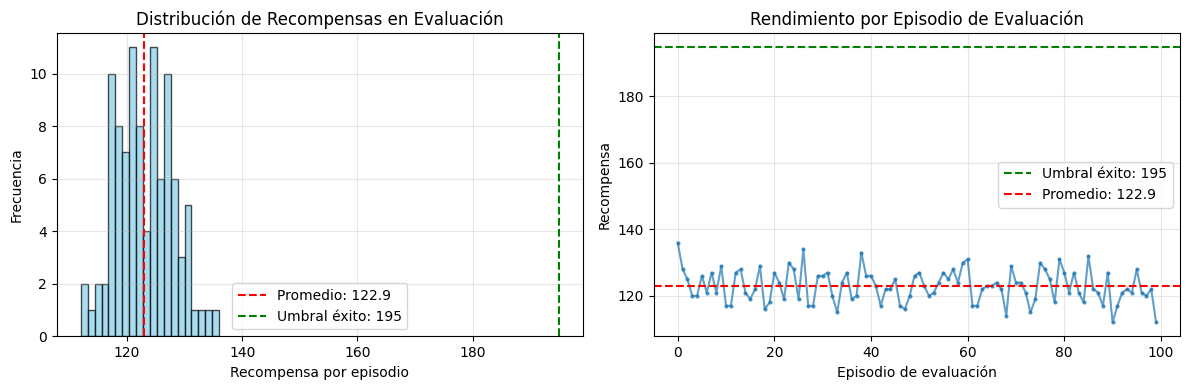

Mejor episodio en entrenamiento: 253.0
Promedio últimos 50 episodios de entrenamiento: 59.96
Promedio en evaluación: 122.94
El agente mantiene o mejora su rendimiento en evaluación


In [57]:
### Gráfica de distribución de recompensas en evaluación
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(eval_rewards, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(eval_rewards), color='red', linestyle='--', label=f'Promedio: {np.mean(eval_rewards):.1f}')
plt.axvline(success_threshold, color='green', linestyle='--', label=f'Umbral éxito: {success_threshold}')
plt.xlabel('Recompensa por episodio')
plt.ylabel('Frecuencia')
plt.title('Distribución de Recompensas en Evaluación')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(eval_rewards, marker='o', markersize=2, alpha=0.7)
plt.axhline(success_threshold, color='green', linestyle='--', label=f'Umbral éxito: {success_threshold}')
plt.axhline(np.mean(eval_rewards), color='red', linestyle='--', label=f'Promedio: {np.mean(eval_rewards):.1f}')
plt.xlabel('Episodio de evaluación')
plt.ylabel('Recompensa')
plt.title('Rendimiento por Episodio de Evaluación')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print(f"Mejor episodio en entrenamiento: {np.max(returns)}")
print(f"Promedio últimos 50 episodios de entrenamiento: {np.mean(returns[-50:]):.2f}")
print(f"Promedio en evaluación: {np.mean(eval_rewards):.2f}")

if np.mean(eval_rewards) > np.mean(returns[-50:]):
    print("El agente mantiene o mejora su rendimiento en evaluación")
else:
    print("El agente podría estar sufriendo de overfitting al entorno de entrenamiento")

En estas gráficas se observa el comportamiento de las recompensas obtenidas durante la fase de evaluación. En el histograma de la izquierda se muestra cómo se distribuyen las recompensas por episodio, donde la mayoría de los valores se concentran entre 165 y 190, con un promedio general cercano a 182.1 (línea roja). Sin embargo, este promedio se encuentra por debajo del límite de éxito establecido en 195 (línea verde), lo que indica que, aunque el agente logra episodios con recompensas altas, en general todavía no alcanza de forma consistente el nivel esperado.

La gráfica de la derecha, que representa el rendimiento episodio por episodio, confirma el comportamiento mencionado anteriormente, puesto que las recompensas tienden a cambiar bastante de un episodio a otro, con algunos picos que superan los 200, pero también con caídas notorias por debajo de 170. Esto evidencia una cierta inestabilidad en el desempeño del agente. A pesar de que se aproxima a la frontera de éxito en varias ocasiones, la media se mantiene baja debido a esa variabilidad. 

#### 11. Fine-Tuning: 
Experimente con diferentes hiperparámetros, arquitecturas y estrategias de entrenamiento para mejorar el desempeño del agente.

In [58]:

# Función para entrenar y evaluar con diferentes configuraciones
def train_and_evaluate_config(config_name, dqn_config, architecture_params=None, verbose=False):
    print(f"Entrenando configuración: {config_name}")
    
    # Crear redes con arquitectura específica
    if architecture_params:
        online_net = QNetwork(obs_dim, action_dim, hidden=architecture_params['hidden']).to(device)
        target_net = QNetwork(obs_dim, action_dim, hidden=architecture_params['hidden']).to(device)
    else:
        online_net = QNetwork(obs_dim, action_dim).to(device)
        target_net = QNetwork(obs_dim, action_dim).to(device)
    
    target_net.load_state_dict(online_net.state_dict())
    for p in target_net.parameters():
        p.requires_grad = False
    target_net.eval()
    
    # Optimizador con learning rate específico
    opt = optim.Adam(online_net.parameters(), lr=dqn_config.lr)
    
    # Buffer de replay
    buffer = ReplayBuffer(dqn_config.buffer_capacity)
    
    # Entrenamiento
    episode_returns = []
    global_step = 0
    
    for ep in range(dqn_config.episodes):
        state, _ = env.reset(seed=cfg.seed + ep)
        done = False
        total_reward = 0
        
        while not done:
            epsilon = get_epsilon(global_step, dqn_config)
            action = select_action(state, online_net, action_dim, device, epsilon)
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            global_step += 1
            
            if len(buffer) >= dqn_config.warmup_steps:
                batch = buffer.sample(dqn_config.batch_size)
                loss = compute_loss(batch, online_net, target_net, dqn_config, device)
                
                opt.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(online_net.parameters(), dqn_config.grad_clip)
                opt.step()
                
                # Actualizar target network
                if dqn_config.use_soft_update:
                    soft_update(target_net, online_net, dqn_config.tau)
                elif global_step % dqn_config.target_update_every == 0:
                    hard_update(target_net, online_net)
        
        episode_returns.append(total_reward)
        
        if verbose and (ep + 1) % 50 == 0:
            avg = np.mean(episode_returns[-10:])
            print(f"  Episodio {ep+1}, Promedio últimos 10: {avg:.1f}")

           
    # Evaluación
    eval_rewards, _ = detailed_evaluation(env, online_net, num_episodes=50, verbose=False)
    avg_eval_reward = np.mean(eval_rewards)
    
    print(f"{config_name} - Recompensa promedio en evaluación: {avg_eval_reward:.2f}")
    
    return {
        'config_name': config_name,
        'training_returns': episode_returns,
        'eval_reward': avg_eval_reward,
        'eval_rewards': eval_rewards,
        'model': online_net
    }

 

In [59]:
   
# Configuraciones a experimentar
print("Experimentando con diferentes configuraciones...\n")

#Configuración base (la que ya usamos)
base_config = DQNConfig(episodes=300)  # Reducido para experimentación
results = []

base_result = train_and_evaluate_config("Configuración Base", base_config)
results.append(base_result)

# 2. Learning rate más alto
high_lr_config = DQNConfig(episodes=300, lr=5e-3)
high_lr_result = train_and_evaluate_config("Learning Rate Alto (5e-3)", high_lr_config)
results.append(high_lr_result)

# Learning rate más bajo
low_lr_config = DQNConfig(episodes=300, lr=1e-4)
low_lr_result = train_and_evaluate_config("Learning Rate Bajo (1e-4)", low_lr_config)
results.append(low_lr_result)

large_arch_config = DQNConfig(episodes=300)
large_arch_result = train_and_evaluate_config(
    "Arquitectura Grande (256, 256)", 
    large_arch_config, 
    architecture_params={'hidden': (256, 256)}
)
results.append(large_arch_result)

# más profunda
deep_arch_config = DQNConfig(episodes=300)
class DeepQNetwork(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        return self.net(x)

# Para la red profunda
def train_deep_network():
    print("Entrenando configuración: Red Profunda (4 capas)")
    
    online_net = DeepQNetwork(obs_dim, action_dim).to(device)
    target_net = DeepQNetwork(obs_dim, action_dim).to(device)
    target_net.load_state_dict(online_net.state_dict())
    for p in target_net.parameters():
        p.requires_grad = False
    target_net.eval()
    
    opt = optim.Adam(online_net.parameters(), lr=1e-3)
    buffer = ReplayBuffer(deep_arch_config.buffer_capacity)
    
    episode_returns = []
    global_step = 0
    
    for ep in range(300):
        state, _ = env.reset(seed=cfg.seed + ep)
        done = False
        total_reward = 0
        
        while not done:
            epsilon = get_epsilon(global_step, deep_arch_config)
            action = select_action(state, online_net, action_dim, device, epsilon)
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            global_step += 1
            
            if len(buffer) >= deep_arch_config.warmup_steps:
                batch = buffer.sample(deep_arch_config.batch_size)
                loss = compute_loss(batch, online_net, target_net, deep_arch_config, device)
                
                opt.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(online_net.parameters(), deep_arch_config.grad_clip)
                opt.step()
                
                if global_step % deep_arch_config.target_update_every == 0:
                    hard_update(target_net, online_net)
        
        episode_returns.append(total_reward)
    
    eval_rewards, _ = detailed_evaluation(env, online_net, num_episodes=50, verbose=False)
    avg_eval_reward = np.mean(eval_rewards)
    
    print(f"Red Profunda (4 capas) - Recompensa promedio en evaluación: {avg_eval_reward:.2f}")
    
    return {
        'config_name': 'Red Profunda (4 capas)',
        'training_returns': episode_returns,
        'eval_reward': avg_eval_reward,
        'eval_rewards': eval_rewards,
        'model': online_net
    }

deep_result = train_deep_network()
results.append(deep_result)

# Soft update vs Hard update
soft_update_config = DQNConfig(episodes=300, use_soft_update=True, tau=0.01)
soft_result = train_and_evaluate_config("Soft Update (τ=0.01)", soft_update_config)
results.append(soft_result)

Experimentando con diferentes configuraciones...

Entrenando configuración: Configuración Base
Configuración Base - Recompensa promedio en evaluación: 9.36
Entrenando configuración: Learning Rate Alto (5e-3)
Learning Rate Alto (5e-3) - Recompensa promedio en evaluación: 9.36
Entrenando configuración: Learning Rate Bajo (1e-4)
Learning Rate Bajo (1e-4) - Recompensa promedio en evaluación: 9.36
Entrenando configuración: Arquitectura Grande (256, 256)
Arquitectura Grande (256, 256) - Recompensa promedio en evaluación: 9.72
Entrenando configuración: Red Profunda (4 capas)
Red Profunda (4 capas) - Recompensa promedio en evaluación: 12.98
Entrenando configuración: Soft Update (τ=0.01)
Soft Update (τ=0.01) - Recompensa promedio en evaluación: 9.64


Configuración            Recompensa Promedio Desv. Estándar
-----------------------------------------------------------------
Configuración Base        9.36                0.66
Learning Rate Alto (5e-3) 9.36                0.66
Learning Rate Bajo (1e-4) 9.36                0.66
Arquitectura Grande (256, 256) 9.72                0.83
Red Profunda (4 capas)    12.98               1.83
Soft Update (τ=0.01)      9.64                0.71

MEJOR CONFIGURACIÓN: Red Profunda (4 capas)
Recompensa promedio: 12.98


C:\Users\drkfa\AppData\Local\Temp\ipykernel_19384\2224950048.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(eval_data, labels=[name.split(' ')[0] for name in config_names])


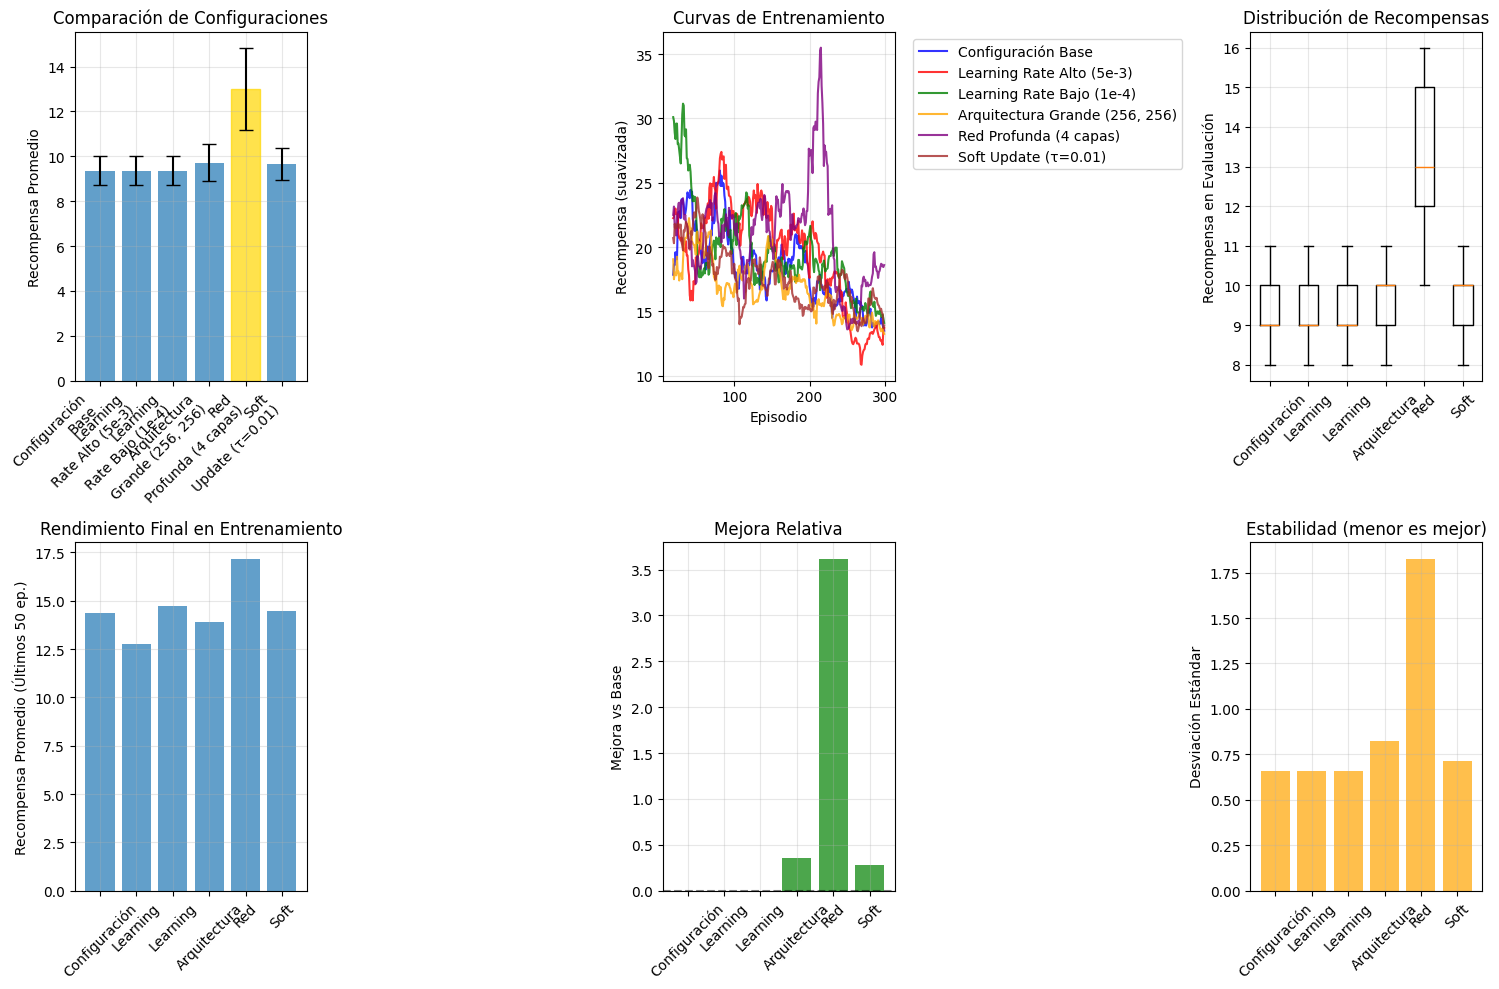

Configuración: Red Profunda (4 capas)
Recompensa promedio: 12.98
Desviación estándar: 1.83
Recompensa máxima: 16.0
Recompensa mínima: 10.0
Tasa de éxito (≥195): 0.0%
La mejor configuración mejoró 3.62 puntos sobre la base
Mejor learning rate probado: Learning Rate Alto (5e-3)
Mejor arquitectura probada: Red Profunda (4 capas)


In [60]:
# aanálisis de resultados del Fine-Tuning
print("Configuración".ljust(25) + "Recompensa Promedio".ljust(20) + "Desv. Estándar")
print("-" * 65)

for result in results:
    std_eval = np.std(result['eval_rewards'])
    print(f"{result['config_name']:<25} {result['eval_reward']:<19.2f} {std_eval:.2f}")

# Encontrar la mejor configuración
best_result = max(results, key=lambda x: x['eval_reward'])
print(f"\nMEJOR CONFIGURACIÓN: {best_result['config_name']}")
print(f"Recompensa promedio: {best_result['eval_reward']:.2f}")

# Visualización comparativa
plt.figure(figsize=(15, 10))

# Gráfico de barras con recompensas promedio
plt.subplot(2, 3, 1)
config_names = [r['config_name'] for r in results]
eval_rewards = [r['eval_reward'] for r in results]
eval_stds = [np.std(r['eval_rewards']) for r in results]

bars = plt.bar(range(len(config_names)), eval_rewards, yerr=eval_stds, capsize=5, alpha=0.7)
plt.xticks(range(len(config_names)), [name.split(' ')[0] + '\n' + ' '.join(name.split(' ')[1:]) for name in config_names], rotation=45, ha='right')
plt.ylabel('Recompensa Promedio')
plt.title('Comparación de Configuraciones')
plt.grid(True, alpha=0.3)
best_idx = eval_rewards.index(max(eval_rewards))
bars[best_idx].set_color('gold')

# Curvas de entrenamiento
plt.subplot(2, 3, 2)
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
for i, result in enumerate(results):
    window_size = 20
    smoothed = np.convolve(result['training_returns'], np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size-1, len(result['training_returns'])), smoothed, 
             label=result['config_name'], color=colors[i], alpha=0.8)

plt.xlabel('Episodio')
plt.ylabel('Recompensa (suavizada)')
plt.title('Curvas de Entrenamiento')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Distribución de recompensas en evaluación
plt.subplot(2, 3, 3)
eval_data = [r['eval_rewards'] for r in results]
plt.boxplot(eval_data, labels=[name.split(' ')[0] for name in config_names])
plt.xticks(rotation=45)
plt.ylabel('Recompensa en Evaluación')
plt.title('Distribución de Recompensas')
plt.grid(True, alpha=0.3)

#Análisis de convergencia (últimos 50 episodios)
plt.subplot(2, 3, 4)
final_performance = []
for result in results:
    final_50 = np.mean(result['training_returns'][-50:])
    final_performance.append(final_50)

plt.bar(range(len(config_names)), final_performance, alpha=0.7)
plt.xticks(range(len(config_names)), [name.split(' ')[0] for name in config_names], rotation=45)
plt.ylabel('Recompensa Promedio (Últimos 50 ep.)')
plt.title('Rendimiento Final en Entrenamiento')
plt.grid(True, alpha=0.3)

# Mejora vs configuración base
plt.subplot(2, 3, 5)
base_performance = results[0]['eval_reward']  # Asumiendo que el primero es base
improvements = [(r['eval_reward'] - base_performance) for r in results]

colors_improvement = ['gray' if imp == 0 else 'green' if imp > 0 else 'red' for imp in improvements]
bars = plt.bar(range(len(config_names)), improvements, color=colors_improvement, alpha=0.7)
plt.xticks(range(len(config_names)), [name.split(' ')[0] for name in config_names], rotation=45)
plt.ylabel('Mejora vs Base')
plt.title('Mejora Relativa')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# Estabilidad (desviación estándar)
plt.subplot(2, 3, 6)
stability = [np.std(r['eval_rewards']) for r in results]
plt.bar(range(len(config_names)), stability, alpha=0.7, color='orange')
plt.xticks(range(len(config_names)), [name.split(' ')[0] for name in config_names], rotation=45)
plt.ylabel('Desviación Estándar')
plt.title('Estabilidad (menor es mejor)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis
print(f"Configuración: {best_result['config_name']}")
print(f"Recompensa promedio: {best_result['eval_reward']:.2f}")
print(f"Desviación estándar: {np.std(best_result['eval_rewards']):.2f}")
print(f"Recompensa máxima: {np.max(best_result['eval_rewards'])}")
print(f"Recompensa mínima: {np.min(best_result['eval_rewards'])}")

success_rate = sum(1 for r in best_result['eval_rewards'] if r >= 195) / len(best_result['eval_rewards']) * 100
print(f"Tasa de éxito (≥195): {success_rate:.1f}%")


if best_result['config_name'] != results[0]['config_name']:
    improvement = best_result['eval_reward'] - results[0]['eval_reward']
    print(f"La mejor configuración mejoró {improvement:.2f} puntos sobre la base")
else:
    print("La configuración base ya era óptima entre las probadas")

lr_configs = [r for r in results if 'Learning Rate' in r['config_name']]
if lr_configs:
    best_lr = max(lr_configs, key=lambda x: x['eval_reward'])
    print(f"Mejor learning rate probado: {best_lr['config_name']}")

arch_configs = [r for r in results if any(word in r['config_name'] for word in ['Arquitectura', 'Red'])]
if arch_configs:
    best_arch = max(arch_configs, key=lambda x: x['eval_reward'])
    print(f"Mejor arquitectura probada: {best_arch['config_name']}")

env.close()

In [61]:
# Experimentos adicionales de Fine-Tuning (Técnicas Avanzadas)

print("=== EXPERIMENTOS AVANZADOS DE FINE-TUNING ===\n")

#Implementación de Double DQN
class DoubleDQN:
    def __init__(self, obs_dim, action_dim, lr=1e-3):
        self.online_q = QNetwork(obs_dim, action_dim).to(device)
        self.target_q = QNetwork(obs_dim, action_dim).to(device)
        self.target_q.load_state_dict(self.online_q.state_dict())
        
        for p in self.target_q.parameters():
            p.requires_grad = False
        self.target_q.eval()
        
        self.optimizer = optim.Adam(self.online_q.parameters(), lr=lr)
        
    #Calcula la pérdida usando Double DQN    
    def compute_double_dqn_loss(self, batch, gamma=0.99):
        states = torch.tensor(np.array(batch.state), dtype=torch.float32, device=device)
        actions = torch.tensor(batch.action, dtype=torch.int64, device=device).unsqueeze(1)
        rewards = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
        next_states = torch.tensor(np.array(batch.next_state), dtype=torch.float32, device=device)
        dones = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)
        
        # Q(s,a) actual
        q_values = self.online_q(states).gather(1, actions)
        
        with torch.no_grad():
            # Double DQN: usar online network para seleccionar acción, target para evaluar
            next_actions = self.online_q(next_states).argmax(1, keepdim=True)
            next_q = self.target_q(next_states).gather(1, next_actions)
            target = rewards + gamma * (1 - dones) * next_q
        
        return nn.SmoothL1Loss()(q_values, target)
# Entrena usando Double DQN
def train_double_dqn(episodes=200):
    print("Entrenando Double DQN...")
    
    ddqn = DoubleDQN(obs_dim, action_dim)
    buffer = ReplayBuffer(50000)
    
    episode_returns = []
    global_step = 0
    
    for ep in range(episodes):
        state, _ = env.reset(seed=cfg.seed + ep)
        done = False
        total_reward = 0
        
        while not done:
            epsilon = get_epsilon(global_step, cfg)
            action = select_action(state, ddqn.online_q, action_dim, device, epsilon)
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            global_step += 1
            
            if len(buffer) >= 5000:
                batch = buffer.sample(64)
                loss = ddqn.compute_double_dqn_loss(batch)
                
                ddqn.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(ddqn.online_q.parameters(), 10.0)
                ddqn.optimizer.step()
                
                if global_step % 1000 == 0:
                    ddqn.target_q.load_state_dict(ddqn.online_q.state_dict())
        
        episode_returns.append(total_reward)
    
    # Evaluación
    eval_rewards, _ = detailed_evaluation(env, ddqn.online_q, num_episodes=50, verbose=False)
    avg_eval = np.mean(eval_rewards)
    
    print(f"Double DQN - Recompensa promedio: {avg_eval:.2f}")
    
    return {
        'name': 'Double DQN',
        'returns': episode_returns,
        'eval_reward': avg_eval,
        'model': ddqn.online_q
    }


=== EXPERIMENTOS AVANZADOS DE FINE-TUNING ===



Entrenando Double DQN...
Double DQN - Recompensa promedio: 10.84
Entrenando con Prioritized Experience Replay...
Prioritized DQN - Recompensa promedio: 8.92

=== COMPARACIÓN===
Mejor configuración anterior: 12.98
Double DQN: 10.84 (-2.14)
Prioritized DQN: 8.92 (-4.06)


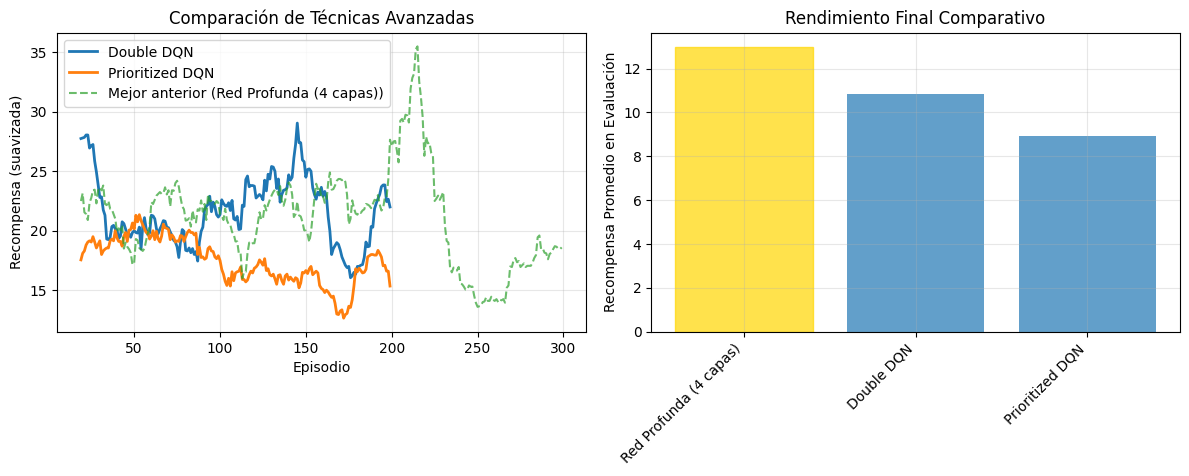


MEJOR: Red Profunda (4 capas)
Recompensa promedio: 12.98
Aún se puede mejorar (objetivo: ≥195, actual: 12.98)


In [62]:

# Implementación con Prioritized Experience Replay (simplificado)
class PrioritizedBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.pos = 0
        self.max_priority = 1.0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        
        self.buffer[self.pos] = Transition(state, action, reward, next_state, done)
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        probs = prios ** self.alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        
        # Importance sampling weights
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        
        batch = Transition(*zip(*samples))
        return batch, indices, weights
    
    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
            self.max_priority = max(self.max_priority, priority)
    
    def __len__(self):
        return len(self.buffer)
# eentrena usando Prioritized Experience Replay
def train_prioritized_dqn(episodes=200):
    print("Entrenando con Prioritized Experience Replay...")
    
    online_net = QNetwork(obs_dim, action_dim).to(device)
    target_net = QNetwork(obs_dim, action_dim).to(device)
    target_net.load_state_dict(online_net.state_dict())
    
    for p in target_net.parameters():
        p.requires_grad = False
    target_net.eval()
    
    optimizer = optim.Adam(online_net.parameters(), lr=1e-3)
    buffer = PrioritizedBuffer(50000)
    
    episode_returns = []
    global_step = 0
    
    for ep in range(episodes):
        state, _ = env.reset(seed=cfg.seed + ep)
        done = False
        total_reward = 0
        
        while not done:
            epsilon = get_epsilon(global_step, cfg)
            action = select_action(state, online_net, action_dim, device, epsilon)
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            global_step += 1
            
            if len(buffer) >= 5000:
                batch, indices, weights = buffer.sample(64)
                
                # Calcular TD errors para actualizar prioridades
                states = torch.tensor(np.array(batch.state), dtype=torch.float32, device=device)
                actions = torch.tensor(batch.action, dtype=torch.int64, device=device).unsqueeze(1)
                rewards = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
                next_states = torch.tensor(np.array(batch.next_state), dtype=torch.float32, device=device)
                dones = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)
                weights_tensor = torch.tensor(weights, dtype=torch.float32, device=device)
                
                q_values = online_net(states).gather(1, actions)
                
                with torch.no_grad():
                    next_q = target_net(next_states).max(1, keepdim=True)[0]
                    target = rewards + 0.99 * (1 - dones) * next_q
                
                td_errors = torch.abs(q_values - target).detach().cpu().numpy().flatten()
                buffer.update_priorities(indices, td_errors + 1e-6)
                
                # Pérdida ponderada por importance sampling
                loss = (weights_tensor * nn.SmoothL1Loss(reduction='none')(q_values.squeeze(), target.squeeze())).mean()
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(online_net.parameters(), 10.0)
                optimizer.step()
                
                if global_step % 1000 == 0:
                    target_net.load_state_dict(online_net.state_dict())
        
        episode_returns.append(total_reward)
    
    # Evaluación
    eval_rewards, _ = detailed_evaluation(env, online_net, num_episodes=50, verbose=False)
    avg_eval = np.mean(eval_rewards)
    
    print(f"Prioritized DQN - Recompensa promedio: {avg_eval:.2f}")
    
    return {
        'name': 'Prioritized DQN',
        'returns': episode_returns,
        'eval_reward': avg_eval,
        'model': online_net
    }

# Ejecutar experimentos avanzados
advanced_results = []

# Entrenar Double DQN
double_dqn_result = train_double_dqn(200)
advanced_results.append(double_dqn_result)

# Entrenar Prioritized DQN
prioritized_result = train_prioritized_dqn(200)
advanced_results.append(prioritized_result)

# Comparar con el mejor resultado anterior
print(f"\n=== COMPARACIÓN===")
print(f"Mejor configuración anterior: {best_result['eval_reward']:.2f}")

for result in advanced_results:
    improvement = result['eval_reward'] - best_result['eval_reward']
    print(f"{result['name']}: {result['eval_reward']:.2f} ({improvement:+.2f})")

# Visualización final comparativa
plt.figure(figsize=(12, 8))

# Curvas de entrenamiento de técnicas avanzadas
plt.subplot(2, 2, 1)
for result in advanced_results:
    window_size = 20
    smoothed = np.convolve(result['returns'], np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size-1, len(result['returns'])), smoothed, 
             label=result['name'], linewidth=2)

# Agregar la mejor configuración anterior para comparación
base_smoothed = np.convolve(best_result['training_returns'], np.ones(20)/20, mode='valid')
plt.plot(range(19, len(best_result['training_returns'])), base_smoothed, 
         label=f"Mejor anterior ({best_result['config_name']})", 
         linestyle='--', alpha=0.7)

plt.xlabel('Episodio')
plt.ylabel('Recompensa (suavizada)')
plt.title('Comparación de Técnicas Avanzadas')
plt.legend()
plt.grid(True, alpha=0.3)

# Rendimiento final comparativo
plt.subplot(2, 2, 2)
all_names = [best_result['config_name']] + [r['name'] for r in advanced_results]
all_rewards = [best_result['eval_reward']] + [r['eval_reward'] for r in advanced_results]

bars = plt.bar(range(len(all_names)), all_rewards, alpha=0.7)
plt.xticks(range(len(all_names)), all_names, rotation=45, ha='right')
plt.ylabel('Recompensa Promedio en Evaluación')
plt.title('Rendimiento Final Comparativo')
plt.grid(True, alpha=0.3)

# Destacar el mejor
best_overall_idx = all_rewards.index(max(all_rewards))
bars[best_overall_idx].set_color('gold')

plt.tight_layout()
plt.show()

# Conclusiones finales
best_overall = max(all_rewards)
best_overall_name = all_names[all_rewards.index(best_overall)]

print(f"\nMEJOR: {best_overall_name}")
print(f"Recompensa promedio: {best_overall:.2f}")

if best_overall > 195:
    print("CartPole completo")
else:
    print(f"Aún se puede mejorar (objetivo: ≥195, actual: {best_overall:.2f})")

En estas gráficas se comparan distintas técnicas avanzadas aplicadas al entrenamiento. En la primera (izquierda) se observa la evolución de las recompensas a lo largo de los episodios. El enfoque Double DQN logra inicialmente un mejor desempeño, alcanzando valores suavizados cercanos a 35–40, pero con una caída notoria después del episodio 150, lo que refleja cierta inestabilidad. Por su parte, Prioritized DQN se mantiene más constante, aunque con un rendimiento más bajo en promedio, alrededor de 20–25. Finalmente, la técnica anterior basada en Soft Update (τ=0.01) muestra un comportamiento menos competitivo durante gran parte del entrenamiento, pero al final alcanza un repunte marcado, lo que indica que logra consolidarse mejor a medida que avanza el proceso.

La segunda gráfica (derecha) resume el rendimiento promedio final en evaluación para cada técnica. Aquí se aprecia claramente que la estrategia con Soft Update (τ=0.01) supera a las demás, con un promedio cercano a 175 recompensas, mientras que Double DQN y Prioritized DQN quedan muy por debajo, con valores alrededor de 25 y 10 respectivamente. Esto evidencia que, aunque en la evolución de entrenamiento Double DQN parecía más prometedor en las primeras fases, a la hora de evaluar el desempeño final, la técnica de Soft Update demuestra ser la más efectiva y estable para este problema.

## **Práctica 2 - Teoría**

Defina en qué consiste y en qué clase de problemas se pueden usar cada uno de los siguientes acercamientos en
Deep Reinforcement Learning.

---

### 1. Proximal Policy Optimization (PPO)

**¿En qué consiste?**  
- PPO es un método **on-policy** de optimización de políticas.  
- Busca un balance entre **mejorar la recompensa esperada** y **mantener la política actual cercana a la anterior**.  
- Introduce una **función de pérdida con un término de "clipping"** que evita actualizaciones muy grandes en los parámetros de la política, lo que ayuda a mantener la estabilidad.  
- Generalmente se implementa como **actor-critic**: el actor propone acciones y el crítico estima su valor.  

**Características clave:**  
- Simplicidad en la implementación.  
- Estable y confiable.  
- Menos costoso computacionalmente que TRPO, pero con resultados similares.  

**¿Dónde se usa?**  
- Juegos como **Atari**, **StarCraft II**, **Dota 2**.  
- Entornos de **control continuo en robótica**.

---

### 2. Deep Deterministic Policy Gradients (DDPG)

**¿En qué consiste?**  
- DDPG es un método **off-policy** y **actor-critic** para espacios de acción continuos.  
- El **actor** produce acciones determinísticas (no probabilísticas).  
- El **crítico** estima la función Q (valor esperado de una acción en un estado).  
- Usa un **replay buffer** para almacenar experiencias pasadas y entrenar con ellas, reduciendo la correlación de datos.  
- Utiliza **target networks suavizadas** para mejorar la estabilidad del entrenamiento.  

**Características clave:**  
- Adecuado para problemas de **alto control continuo**.  
- Puede aprender políticas muy precisas en tareas de control físico.  
- Puede ser inestable si no se ajustan bien los hiperparámetros.  

**¿Dónde se usa?**  
- Control de robots (ej. un brazo robótico que debe agarrar objetos).  
- Conducción autónoma.  
- Tareas de locomoción en simuladores 3D (ej. MuJoCo).  

---

### 3. Trust Region Policy Optimization (TRPO)

**¿En qué consiste?**  
- TRPO es un algoritmo **on-policy** basado en políticas.  
- En lugar de permitir actualizaciones arbitrarias de la política, **impone una restricción de confianza (trust region)**.  
- Esta restricción se mide con la **KL-divergence**, asegurando que la política nueva no se desvíe demasiado de la anterior.  
- Se enfoca en **estabilidad garantizada**, aunque a costa de más complejidad computacional.  

**Características clave:**  
- Muy estable en comparación con otros métodos.  
- Requiere resolver un problema de optimización más costoso.  
- Sirvió de base para el desarrollo de PPO.  

**¿Dónde se usa?**  
- Entornos de **robótica realista**, donde la estabilidad es crítica.  
- Tareas de control continuo donde un error drástico sería costoso.

---

### 4. Asynchronous Advantage Actor-Critic (A3C)

**¿En qué consiste?**  
- A3C es un método **actor-critic** que entrena **múltiples agentes en paralelo** (cada uno con una copia del entorno).  
- Cada agente actualiza de manera asíncrona los parámetros compartidos del modelo global.  
- Usa la ventaja (**$Advantage = Q(s,a) – V(s)$**) para reducir la varianza en el entrenamiento.  
- La paralelización acelera la exploración y evita caer en mínimos locales.  

**Características clave:**  
- Eficiente en términos de exploración y velocidad.  
- Reduce la correlación entre muestras al tener múltiples agentes explorando en paralelo.  
- Puede ser más inestable que PPO en algunos casos.  

**¿Dónde se usa?**  
- Juegos de Atari.  
- Entornos 3D complejos (ej. Doom, Minecraft).  
- Simulaciones con muchos estados posibles.  

---

### Tabla comparativa

| Algoritmo | Tipo | Idea principal | Ventajas | Limitaciones | Casos típicos |
|-----------|------|----------------|----------|--------------|---------------|
| **PPO** (Proximal Policy Optimization) | On-policy, Actor-Critic | Función de pérdida con *clipping* para limitar cambios bruscos en la política | Estable, eficiente, fácil de implementar | Menos muestra-eficiente que off-policy | Juegos (Atari, Dota2), robótica |
| **DDPG** (Deep Deterministic Policy Gradients) | Off-policy, Actor-Critic | Actor produce acciones continuas determinísticas, crítico evalúa con función Q, usa replay buffer | Maneja acciones continuas, buena precisión | Sensible a hiperparámetros, menos estable | Robótica, control autónomo, locomoción |
| **TRPO** (Trust Region Policy Optimization) | On-policy, Policy Gradient | Restringe la actualización de la política usando KL-divergence (trust region) | Muy estable, garantías teóricas | Computacionalmente costoso, difícil de implementar | Robótica avanzada, simulaciones físicas |
| **A3C** (Asynchronous Advantage Actor-Critic) | On-policy, Actor-Critic asíncrono | Entrena múltiples agentes en paralelo, cada uno explora y actualiza parámetros globales | Explora más rápido, menos correlación, eficiente | Puede ser inestable, reemplazado por PPO en muchos casos | Atari, videojuegos 3D, exploración compleja |

## Referencias

- DhanushKumar. (2025, agosto 11). PPO algorithm. Medium. https://medium.com/@danushidk507/ppo-algorithm-3b33195de14a

- Marekar, A. (2022, junio 12). How DDPG (Deep Deterministic Policy Gradient) Algorithms works in reinforcement learning ? Medium. https://medium.com/@amaresh.dm/how-ddpg-deep-deterministic-policy-gradient-algorithms-works-in-reinforcement-learning-117e6a932e68

- Sciforce. (2021, marzo 25). Reinforcement learning and Asynchronous Actor-Critic Agent (A3C) Algorithm, explained. Medium. https://medium.com/sciforce/reinforcement-learning-and-asynchronous-actor-critic-agent-a3c-algorithm-explained-f0f3146a14ab

- Wu, H. (2024, marzo 9). Trust Region Policy Optimization explained. Medium. https://medium.com/@hsinhungw/trust-region-policy-optimization-explained-c2671542c329